# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal 
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
#import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
PATH  = "/Users/simoneboesso/Desktop/RemoteSensing/Semantic segmentation dataset/"

In [3]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

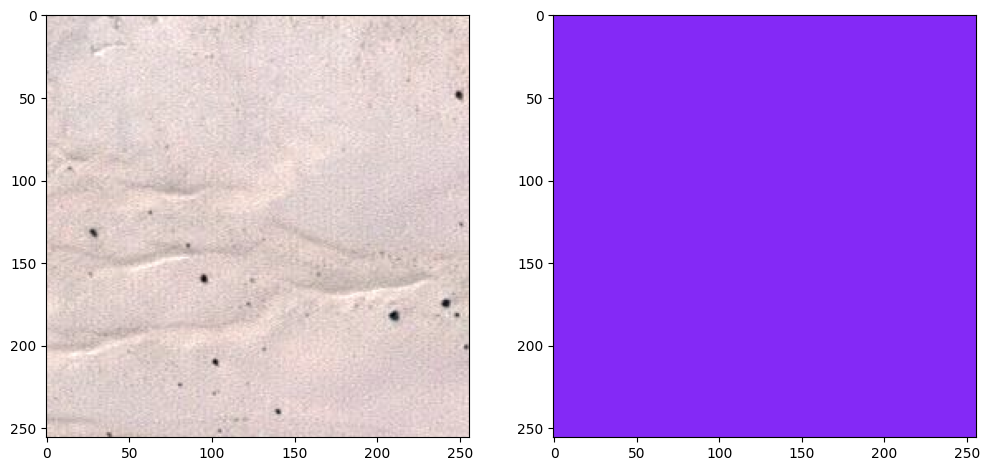

In [4]:
PATCH_GENERATOR.check()

In [5]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels


In [6]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [7]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [8]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [13]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


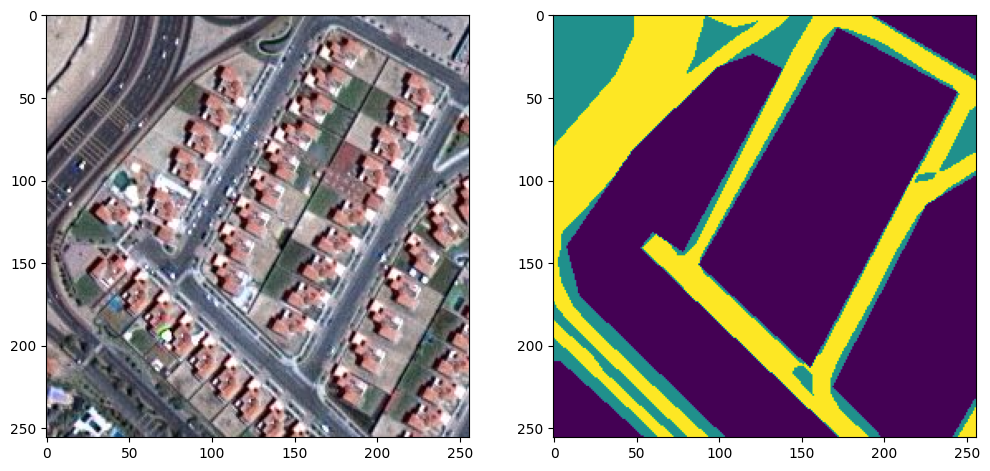

In [17]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()